# General Data Visualization
 - Visualize and explore data generally, without digging into any specific opening move(s).

In [ ]:
from common import *

In [ ]:
db['chessData'].list_collection_names()

In [ ]:
db['chessData']['2023-10'].estimated_document_count()

In [ ]:
cc = db['chessData']['2023-10']
#chessCollection

### Available attributes:
opening, variation, whiteElo, blackElo, winner

In [ ]:
#cc.distinct('opening')

### Group by Opening

In [ ]:
#gr - group
grOpening = { 
  '$group': {
      '_id': '$opening', 
      'count': {'$sum': 1 },
      'whiteWins': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'white']}, 1, 0]
          }
      },
      'blackWins': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'black']}, 1, 0]
          }
      },
      'draw': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'draw']}, 1, 0]
          }
      }
    }
  }

#ag - aggregrated
agOpening = list(cc.aggregate([grOpening]))  


In [ ]:
agOpening

In [ ]:
openingsDf = pd.DataFrame(agOpening)
openingsDf.rename(columns={'_id': 'opening_name'}, inplace=True)
openingsDf.sort_values(by=['count'], ascending=False, inplace=True)
openingsDf.to_csv('TopOpeningsWithWins.csv', index=False, header=True)

In [8]:
openingsDf

,opening_name,count,whiteWins,blackWins,draw
0,Sicilian Defense,9487601,4568623,4546851,372127
1,Queen's Pawn Game,7906789,4018117,3560646,328026
2,French Defense,5613896,2704136,2689052,220708
3,Scandinavian Defense,5019647,2444073,2379180,196394
4,Caro-Kann Defense,4799981,2292282,2312267,195432
...,...,...,...,...,...
151,Venezolana Opening,105,57,43,5
152,Formation,82,39,39,4
153,Dresden Opening,46,8,36,2
154,Veresov Opening,37,14,23,0


### Group by Opening AND Variation

In [72]:
grOpeningVariant = { 
  '$group': {
      '_id': {
          'opening': '$opening',
          'variation': '$variation'
      }, 
      'count': {'$sum': 1},
      'whiteWins': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'white']}, 1, 0]
          }
      },
      'blackWins': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'black']}, 1, 0]
          }
      },
      'draw': {
          '$sum': {
              '$cond': [{'$eq': ['$winner', 'draw']}, 1, 0]
          }
      }
    }
}

agOpeningVariant = list(cc.aggregate([grOpeningVariant]))

In [79]:
openingVariantDf = pd.json_normalize(agOpeningVariant)
openingVariantDf.rename(columns={'_id.opening': 'opening_name', '_id.variation': 'opening_variation'}, inplace=True)
openingVariantDf.sort_values(by=['count'], ascending=False, inplace=True)
openingVariantDf.to_csv('TopOpeningVariantsW.csv', index=False, header=True)

In [ ]:
openingVariantDf

## Visualization

In [128]:
import pandas as pd
import seaborn as sb
from matplotlib import ticker
import matplotlib.pyplot as plt
sb.set_theme(font="Sarabun", font_scale=0.9)#, palette='tab10')

In [ ]:
openingsDf = pd.read_csv('TopOpeningsWithWins.csv')

In [ ]:
openingsDf

In [103]:
def formatForPlotting(df, firstN=10, index='opening_name'):
  return df.head(firstN).sort_values(by='count').drop('count', axis=1).set_index(index).reindex(columns=['whiteWins','draw','blackWins'])

In [136]:
stuffToPlot = formatForPlotting(openingsDf)
focusedOpenings = list(reversed(list(stuffToPlot.index)))

In [95]:
focusedOpenings

["Queen's Gambit Declined",
 'English Opening',
 'Modern Defense',
 "King's Pawn Game",
 'Italian Game',
 'Caro-Kann Defense',
 'Scandinavian Defense',
 'French Defense',
 "Queen's Pawn Game",
 'Sicilian Defense']

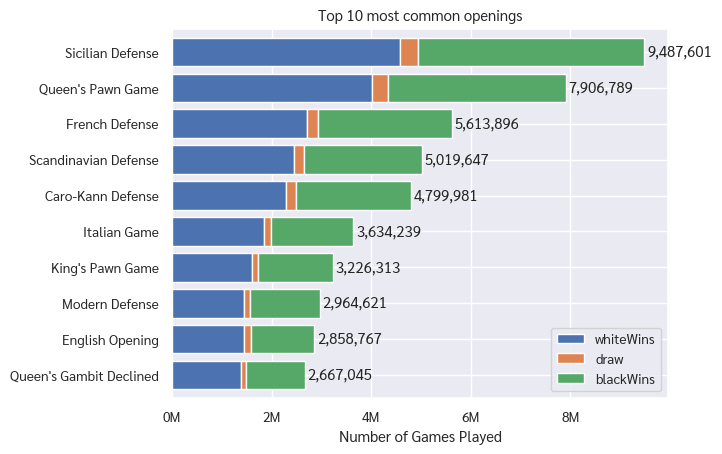

In [67]:
openingPlot = stuffToPlot.plot(kind='barh', stacked=True, title='Top 10 most common openings', ylabel='', xlabel='Number of Games Played', width=0.8)
openingPlot.bar_label(openingPlot.containers[2], fmt='{:,.0f}', padding=2)
openingPlot.xaxis.set_major_formatter(tm_formatter)
openingPlot.xaxis.set_major_locator(ticker.MultipleLocator(base=2*1e6))
openingPlot.xaxis.set_minor_locator(ticker.MultipleLocator(base=1e6/2))

In [ ]:
openingsDf.head(10).sort_values(by='count')
#add white wins in percentage

for winner in ['whiteWins', 'blackWins', 'draw']:
  openingsDf[winner + 'Percent'] = round(openingsDf[winner] / openingsDf['count'] * 100, 2)

In [57]:
openingPlot.get_figure().savefig('Top10OpeningsW.png', dpi=300, facecolor='w', bbox_inches='tight')

### Pie Chart

In [146]:
def plotWinRate(data, title="General", show=True):
  winratesDf = pd.DataFrame([data['whiteWins'].sum(), data['blackWins'].sum(), data['draw'].sum()], index=['White', 'Black', 'Draw'], columns=['count'])
  winrateFig = winratesDf.plot(kind='pie', y='count', title=f'{title} Win Rates', ylabel='', autopct='%1.1f%%').get_figure()
  winrateFig.savefig(f'plots/winrates/{title}.png', dpi=300, facecolor='w', bbox_inches='tight')
  if not show:
    plt.close(winrateFig)

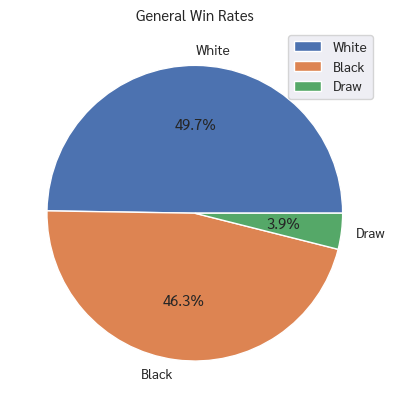

In [132]:
plotWinRate(openingsDf)

## Specific Openings

In [80]:
openingVariantDf = pd.read_csv('TopOpeningVariantsW.csv')

In [141]:
itemno = 1
for openingName in tqdm(focusedOpenings):
  #filter for that varient
  varientDf = openingVariantDf[openingVariantDf['opening_name'] == openingName]

  #reformat data for plotting
  varientToPlot = formatForPlotting(varientDf, index='opening_variation')

  #plot
  varientPlot = varientToPlot.plot(kind='barh', stacked=True, title=f'Top 10 Most used variation in the {openingName}', ylabel='', xlabel='Number of Games Played', width=0.8)
  
  #add labels and ticks
  varientPlot.bar_label(varientPlot.containers[2], fmt='{:,.0f}', padding=2)
  varientPlot.xaxis.set_major_formatter(tm_formatter)
  #varientPlot.xaxis.set_major_locator(ticker.MultipleLocator(base=2*1e5))
  #varientPlot.xaxis.set_minor_locator(ticker.MultipleLocator(base=1e5/2))

  #save
  figure = varientPlot.get_figure()
  figure.savefig(f'plots/varients/{itemno}-{openingName}_W.png', dpi=300, facecolor='w', bbox_inches='tight')
  plt.close(figure)

  itemno += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [147]:
itemno = 1
for openingName in tqdm(focusedOpenings):
  varientDf = openingVariantDf[openingVariantDf['opening_name'] == openingName]
  plotWinRate(varientDf, f"{itemno}-{openingName}", show=False)
  itemno += 1

  0%|          | 0/10 [00:00<?, ?it/s]